# Endpoint Regressor

Train the time-group endpoint regressor with optional classifier/splitter priors.

In [1]:
from pathlib import Path
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import endpoint_regression_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Build aligned parquet/probability inputs.
# Expected prediction shard naming: ml_output_XXX_preds.parquet

data_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(data_dir.glob("ml_output_*.parquet"))
group_probs_dir = data_dir / "group_classifier"
splitter_probs_dir = data_dir / "group_splitter"

# Example: uncomment to select a smaller subset
main_paths = main_paths[:1]

def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    candidates = [
        pred_dir / f"{main_path.stem}_preds.parquet",
        pred_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

paired = []
missing_prob_paths = []
for main_path in main_paths:
    group_path = _pick_pred(group_probs_dir, main_path)
    splitter_path = _pick_pred(splitter_probs_dir, main_path)
    if group_path is not None and splitter_path is not None:
        paired.append((str(main_path.resolve()), str(group_path.resolve()), str(splitter_path.resolve())))
    else:
        missing_prob_paths.append(str(main_path.resolve()))

if not paired:
    raise RuntimeError(
        "No aligned parquet/group-classifier/group-splitter triplets found. "
        "Run group-classifier and group-splitter inference first."
    )
if missing_prob_paths:
    print(f"Warning: missing predictions for {len(missing_prob_paths)} shard(s); skipping those files.")

parquet_paths = [p[0] for p in paired]
group_probs_parquet_paths = [p[1] for p in paired]
group_splitter_parquet_paths = [p[2] for p in paired]
print(f"Using {len(parquet_paths)} shard(s) for endpoint-regressor training.")


Using 1 shard(s) for endpoint-regressor training.


In [3]:
# Run the pipeline
base_loader_config = {
    "mode": "train",
    "use_group_probs": True,
    "use_splitter_probs": True,
    # "batch_size": 64,  # Optional: force a fixed batch size instead of HPO-selected
    "chunk_row_groups": 4,
    "chunk_workers": 0,
    "train_fraction": 0.80,
    "val_fraction": 0.10,
    "test_fraction": 0.10,
    "split_seed": 0,
}

pipeline_config = {
    "loader": {
        # Loader step validates source files and stores source paths.
        "config_json": {"mode": "train", "use_group_probs": True, "use_splitter_probs": True},
    },
    "hpo": {
        "enabled": True,
        "n_trials": 4,
        "max_epochs": 10,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 2,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/endpoint_regressor_hpo.db",
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": 0.125},
            "val": {"split": "val", "sample_fraction": 0.125},
        },
    },
    "train": {
        "max_epochs": 25,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 5,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": True, "mode": "reduce-overhead"},
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": None},
            "val": {"split": "val", "sample_fraction": None},
        },
    },
    "evaluate": {
        "loader_config": {
            "base": dict(base_loader_config),
            "evaluate": {"split": "test", "sample_fraction": None},
        },
    },
    "export": {
        "prefer_cuda": True,
        "export_dir": str(PROJECT_ROOT / "trained_models" / "endpoint_regressor"),
    },
}

run = endpoint_regression_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    group_splitter_parquet_paths=group_splitter_parquet_paths,
    pipeline_config=pipeline_config,
)


Initiating a new run for the pipeline: endpoint_regression_pipeline.
Caching is disabled by default for endpoint_regression_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_endpoint_regressor_dataset has started.
Step load_endpoint_regressor_dataset has finished in 0.131s.
Step tune_endpoint_regressor has started.


[I 2026-02-18 23:48:31,399] Using an existing study with name 'endpoint_regressor_hpo' instead of creating a new one.


[tune_endpoint_regressor] GPU available: True (cuda), used: True
[tune_endpoint_regressor] TPU available: False, using: 0 TPU cores
[tune_endpoint_regressor] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_endpoint_regressor] You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set torch.set_float32_matmul_precision('medium' | 'high') which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[tune_endpoint_regressor] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EndpointRegressor │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 76                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_endpoint_regressor] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_endpoint_regressor] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[I 2026-02-18 23:48:37,899] Trial 23 finished with value: 1.6911487304247343 and parameters: {'batch_size_exp': 5, 'heads': 6, 'hidden': 252, 'layers': 4, 'dropout': 0.2298378523139598, 'lr': 0.004355715910022291, 'weight_decay': 7.727940865936824e-05}. Best is trial 23 with value: 1.6911487304247343.


[tune_endpoint_regressor] GPU available: True (cuda), used: True
[tune_endpoint_regressor] TPU available: False, using: 0 TPU cores
[tune_endpoint_regressor] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_endpoint_regressor] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EndpointRegressor │  4.0 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 60                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:48:41,787] Trial 24 finished with value: 1.9897758227128248 and parameters: {'batch_size_exp': 5, 'heads': 6, 'hidden': 318, 'layers': 3, 'dropout': 0.22992290421382588, 'lr': 0.003883413316912273, 'weight_decay': 0.00010242181235663055}. Best is trial 23 with value: 1.6911487304247343.


[tune_endpoint_regressor] GPU available: True (cuda), used: True
[tune_endpoint_regressor] TPU available: False, using: 0 TPU cores
[tune_endpoint_regressor] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_endpoint_regressor] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EndpointRegressor │  2.2 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 76                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:48:45,693] Trial 25 finished with value: 2.3697789082160363 and parameters: {'batch_size_exp': 5, 'heads': 4, 'hidden': 204, 'layers': 4, 'dropout': 0.28113506790720844, 'lr': 0.005228619675871465, 'weight_decay': 0.00024929663746409776}. Best is trial 23 with value: 1.6911487304247343.


[tune_endpoint_regressor] GPU available: True (cuda), used: True
[tune_endpoint_regressor] TPU available: False, using: 0 TPU cores
[tune_endpoint_regressor] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_endpoint_regressor] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EndpointRegressor │  2.6 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 76                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:48:52,961] Trial 26 finished with value: 2.4124720096588135 and parameters: {'batch_size_exp': 5, 'heads': 6, 'hidden': 222, 'layers': 4, 'dropout': 0.16092948122305548, 'lr': 0.009592661257167904, 'weight_decay': 5.666142502264196e-06}. Best is trial 23 with value: 1.6911487304247343.


Step tune_endpoint_regressor has finished in 21.728s.
Step train_endpoint_regressor has started.
[train_endpoint_regressor] GPU available: True (cuda), used: True
[train_endpoint_regressor] TPU available: False, using: 0 TPU cores
[train_endpoint_regressor] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[train_endpoint_regressor] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ OptimizedModule │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss         │      0 │ train │     0 │
└───┴─────────┴─────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 77                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_endpoint_regressor] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_endpoint_regressor] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[train_endpoint_regressor] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_endpoint_regressor has finished in 2m13s.
Step evaluate_endpoint_regressor has started.
Step evaluate_endpoint_regressor has finished in 2.521s.
Step export_endpoint_regressor has started.
Step export_endpoint_regressor has finished in 0.901s.
Pipeline run has finished in 2m41s.


In [4]:
trained_module = load_step_output(run, "train_endpoint_regressor")
hpo_params = load_step_output(run, "tune_endpoint_regressor")
metrics = load_step_output(run, "evaluate_endpoint_regressor")
export = load_step_output(run, "export_endpoint_regressor")

print("hpo_params:", hpo_params)
if trained_module is not None:
    print("train_epoch_loss_history:", list(trained_module.train_epoch_loss_history))
    print("val_epoch_loss_history:", list(trained_module.val_epoch_loss_history))
    print("train_step_count:", len(trained_module.train_loss_history))
    print("val_step_count:", len(trained_module.val_loss_history))
print("metrics:", metrics)
print("export:", export)


hpo_params: {'lr': 0.004355715910022291, 'weight_decay': 7.727940865936824e-05, 'batch_size': 32, 'study_name': 'endpoint_regressor_hpo', 'storage': 'sqlite:////workspace/.optuna/endpoint_regressor_hpo.db', 'model': {'in_channels': 4, 'group_prob_dimension': 3, 'splitter_prob_dimension': 3, 'hidden': 252, 'heads': 6, 'layers': 4, 'dropout': 0.2298378523139598, 'output_dim': 18}}
train_epoch_loss_history: [5.986577574032731, 2.8675795548656455, 2.3110276092755644, 2.131973144086243, 1.8707623593617315, 1.8139587067204574, 1.6900104215859368, 1.6328678138023114, 1.5586218018660196, 1.5429019537982307, 1.4549683651897993, 1.461981143058788, 1.4191017867826101, 1.3999969659794227, 1.3868402138866558]
val_epoch_loss_history: [24.494772911071777, 2.6679288951718076, 2.9778890366456947, 1.9136843900291287, 1.7715908252463048, 1.5725747468520184, 1.4919894568774166, 1.321488588440175, 1.3782146658216203, 1.2878800399449406, 1.2238178958698196, 1.1983211162138958, 1.186289211925195, 1.176922739

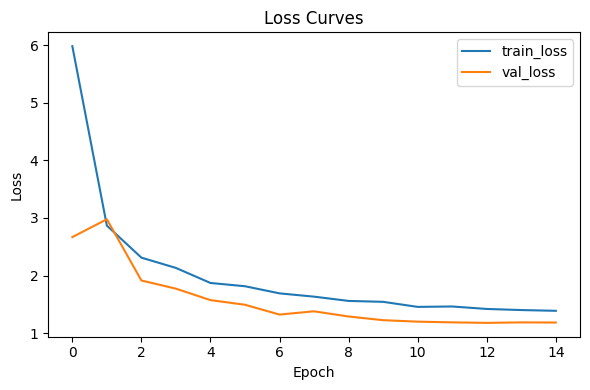

In [5]:
# Plot loss curves
if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")
LossCurvesPlot().render(trained_module, show=True)